In [1]:
import numpy as np
import pandas as pd
import os
import radvel
from radvel.plot import orbit_plots, mcmc_plots
from scipy import optimize
import ktwo19
import ktwo19.io
%pylab inline
%reload_ext autoreload
%autoreload 2 

gphot = pd.read_excel('data/data.xlsx',sheetname='phot-gp',squeeze=True,header=None,index_col=0)
data = ktwo19.io.load_table('rv')
%config InlineBackend.figure_format = 'retina'


def lagprod(t,r):
    n = len(t)
    prod = []
    lag = []
    for i in range(n):
        for j in range(n):
            if i==j:
                continue
            
            prod.append(r[i]*r[j])
            lag.append(t[i] - t[j])
    
    lag = np.abs(np.array(lag))
    prod = np.array(prod)
    return lag, prod

## Note: there was a bug in how bic was being computed in radvel=1.2.0
def bic2(post):
    n = len(post.likelihood.x)
    k = len(post.likelihood.get_vary_params())
    loglike = post.likelihood.logprob()
    bic = np.log(n) * k - 2 * loglike
    return bic

/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/radvel/gp.py:33: ImportWarning: celerite not installed. GP kernals using celerite will not work.
Try installing celerite using 'pip install celerite'
  Try installing celerite using 'pip install celerite'", ImportWarning)


Populating the interactive namespace from numpy and matplotlib


/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


excluding obs: rj197.149


## Model 1: Circular orbits, no trend, white jitter

excluding obs: rj197.149
parameter                     value      vary
per1                        7.92075      False
k1                          7.42371       True
per2                         11.898      False
k2                         0.147633       True
tc1                         1980.38      False
secosw1                           0      False
sesinw1                           0      False
tc2                          1984.3      False
secosw2                           0      False
sesinw2                           0      False
dvdt                              0      False
curv                              0      False
gamma                      -2.72731       True
jit                         8.73638       True

Priors
------



/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xatol
  # This is added back by InteractiveShellApp.init_path()


AIC = 378.1
BIC' = 385.0


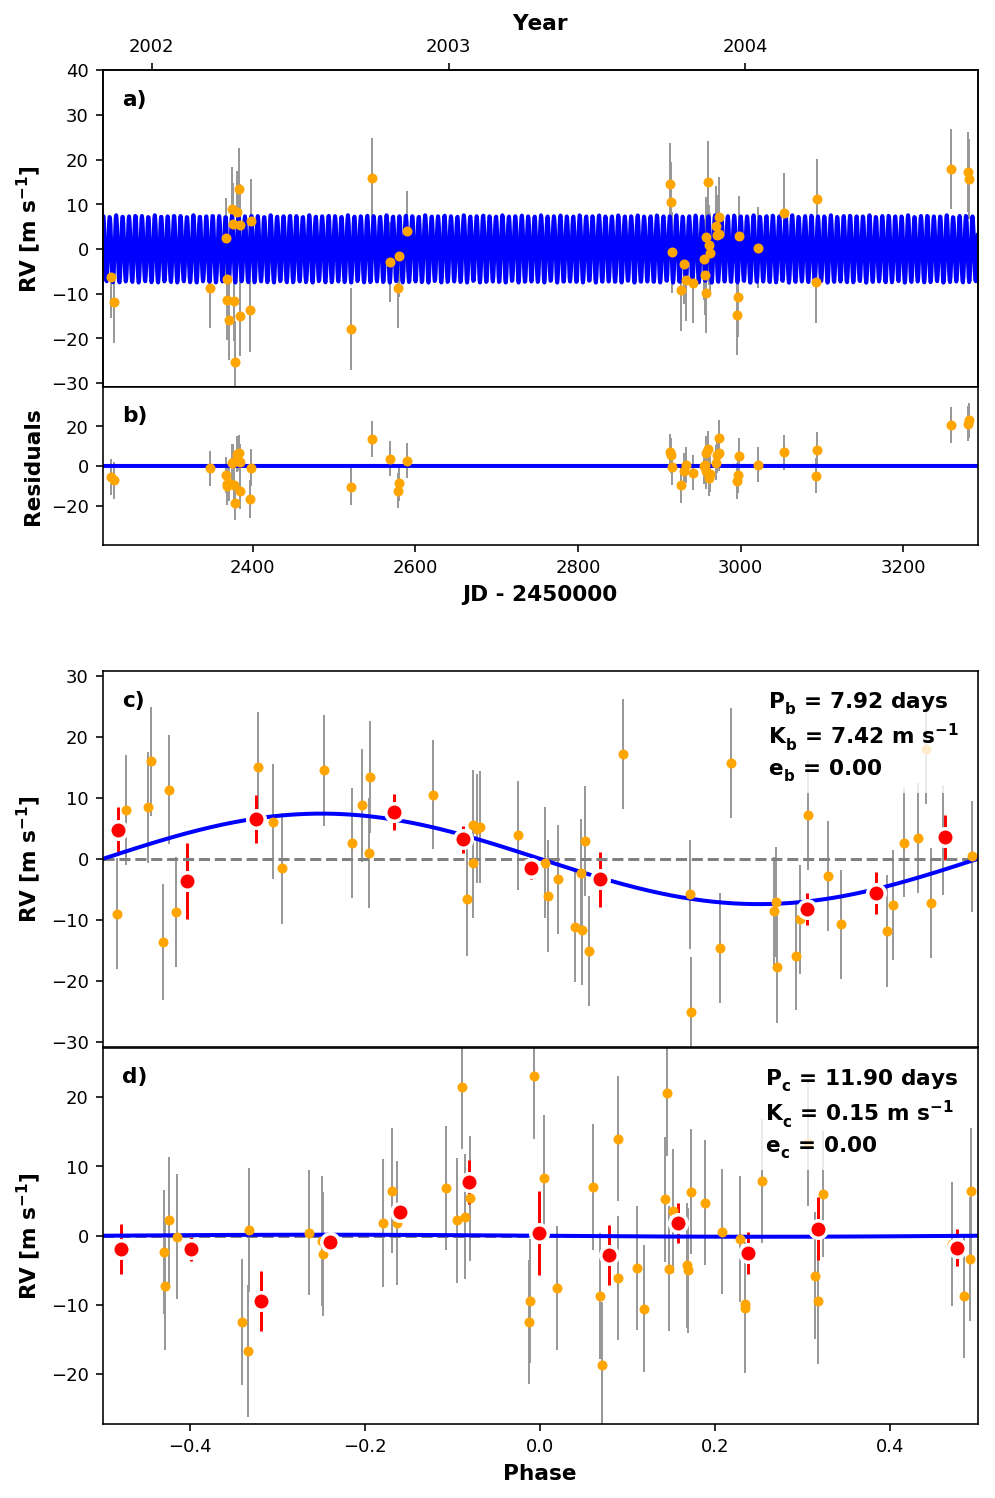

In [12]:
%run analysis/radvel/ktwo19_npl=2-default.py
model = radvel.model.RVModel(params,time_base=time_base)
like = radvel.likelihood.RVLikelihood(model, data.time, data.mnvel,data.errvel)
like.params['gamma'] = radvel.Parameter(value=data.mnvel.mean())
like.params['jit'] = radvel.Parameter(value=1)
like = radvel.likelihood.CompositeLikelihood([like])
post = radvel.posterior.Posterior(like)    

res = optimize.minimize(
    post.neglogprob_array, post.get_vary_params(), method='Powell',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)
print(post)
plotter = orbit_plots.MultipanelPlot(post)
plotter.plot_multipanel()
print "AIC = {:.1f}".format( post.aic())
print "BIC' = {:.1f}".format( bic2(post))

In [3]:
chains = radvel.mcmc(post,nrun=1000,ensembles=3)
print  chains.describe().ix[['mean','std']].T.to_string(float_format='%.3f')

7500/150000 (5.0%) steps complete; Running 8787.78 steps/s; Mean acceptance rate = 62.6%; Min Tz = 514.8; Max G-R = 1.006      
Discarding burn-in now that the chains are marginally well-mixed

82500/150000 (55.0%) steps complete; Running 8711.48 steps/s; Mean acceptance rate = 59.1%; Min Tz = 5303.9; Max G-R = 1.001      
Chains are well-mixed after 82500 steps! MCMC completed in 9.9 seconds


                  mean   std
k1               7.479 2.044
k2               0.152 1.903
gamma           -2.696 1.361
jit              9.241 1.070
lnprobability -186.765 1.528


/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


## Model 2 Circular orbits, trend, white jitter

excluding obs: rj197.149
parameter                     value      vary
per1                        7.92075      False
k1                          9.01704       True
per2                         11.898      False
k2                         0.567047       True
tc1                         1980.38      False
secosw1                           0      False
sesinw1                           0      False
tc2                          1984.3      False
secosw2                           0      False
sesinw2                           0      False
dvdt                      0.0164479       True
curv                              0      False
gamma                      -2.61151       True
jit                         7.14689       True

Priors
------



/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xatol
  if sys.path[0] == '':


AIC = 361.9
BIC' = 370.2


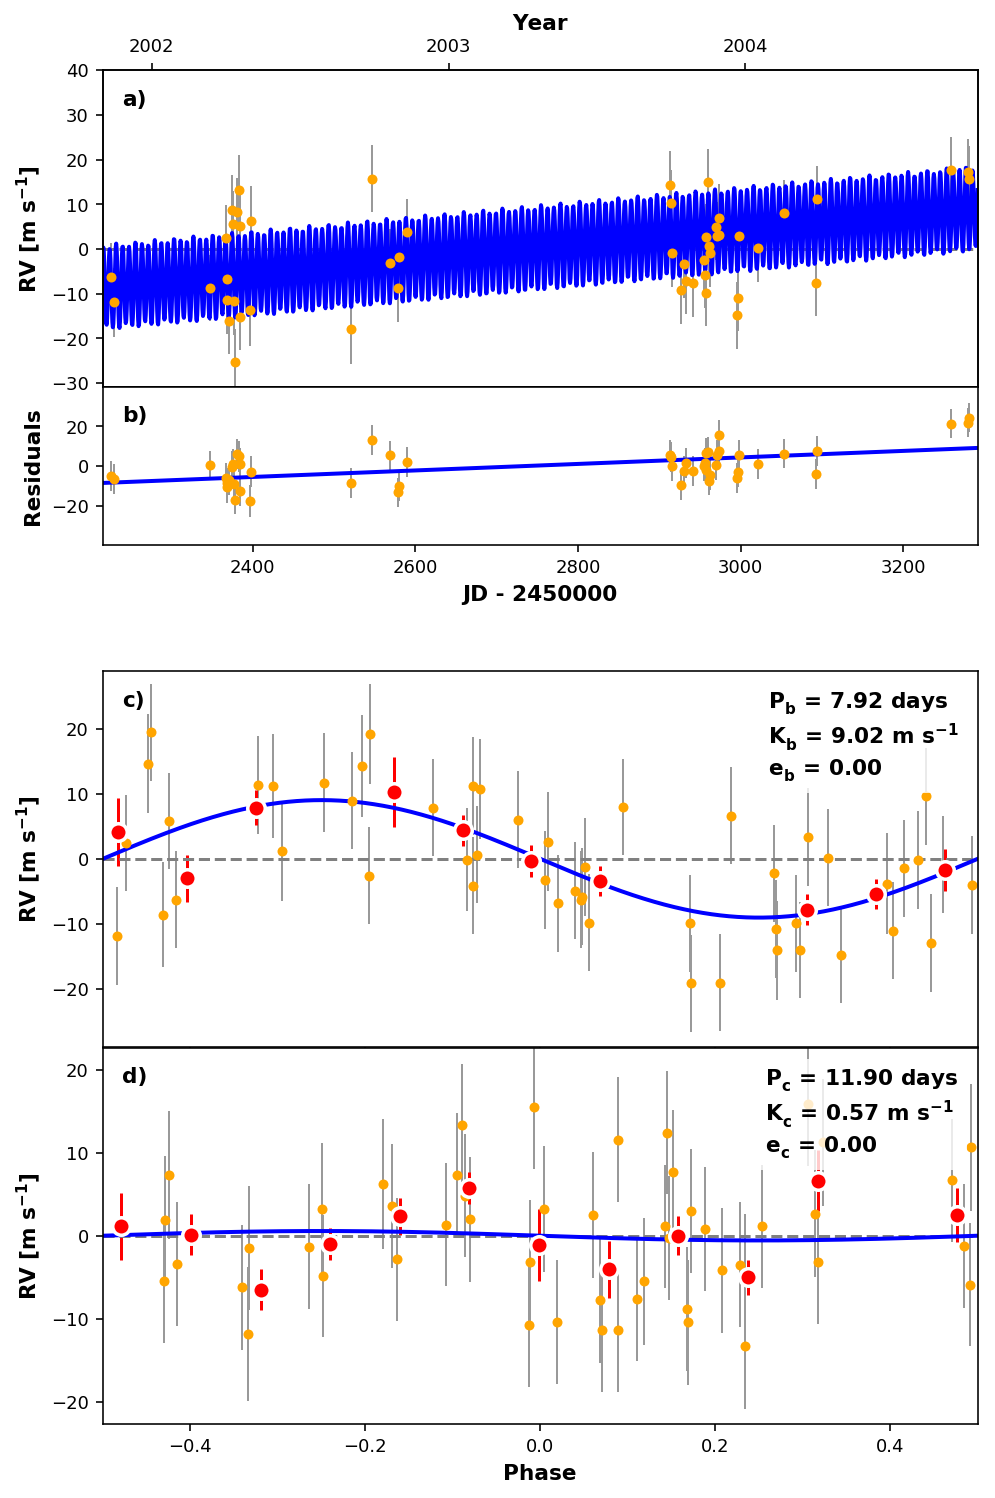

In [10]:
%run analysis/radvel/ktwo19_npl=2-default.py
model = radvel.model.RVModel(params,time_base=time_base)
like = radvel.likelihood.RVLikelihood(model, data.time, data.mnvel,data.errvel)
like.params['dvdt'].vary = True
like.params['gamma'] = radvel.Parameter(value=data.mnvel.mean())
like.params['jit'] = radvel.Parameter(value=1)
like = radvel.likelihood.CompositeLikelihood([like])
post = radvel.posterior.Posterior(like)    

res = optimize.minimize(
    post.neglogprob_array, post.get_vary_params(), method='Powell',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)
print(post)
plotter = orbit_plots.MultipanelPlot(post)
plotter.plot_multipanel()
print "AIC = {:.1f}".format( post.aic())
print "BIC' = {:.1f}".format( bic2(post))

## Model 2a Circular orbits, trend, white jitter

excluding obs: rj197.149
parameter                     value      vary
per1                        7.92075      False
k1                          9.19302       True
per2                         11.898      False
k2                         0.785818       True
tc1                         1980.38      False
secosw1                  -0.0468456       True
sesinw1                    0.322516       True
tc2                          1984.3      False
secosw2                           0      False
sesinw2                           0      False
dvdt                      0.0163778       True
curv                              0      False
secosw3                           0      False
sesinw3                           0      False
gamma                      -2.66843       True
jit                         7.12466       True

Priors
------
e1 constrained to be < 0.99
e2 constrained to be < 0.99
e3 constrained to be < 0.99



/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:19: OptimizeWarning: Unknown solver options: xatol


AIC = 366.8
BIC' = 377.7


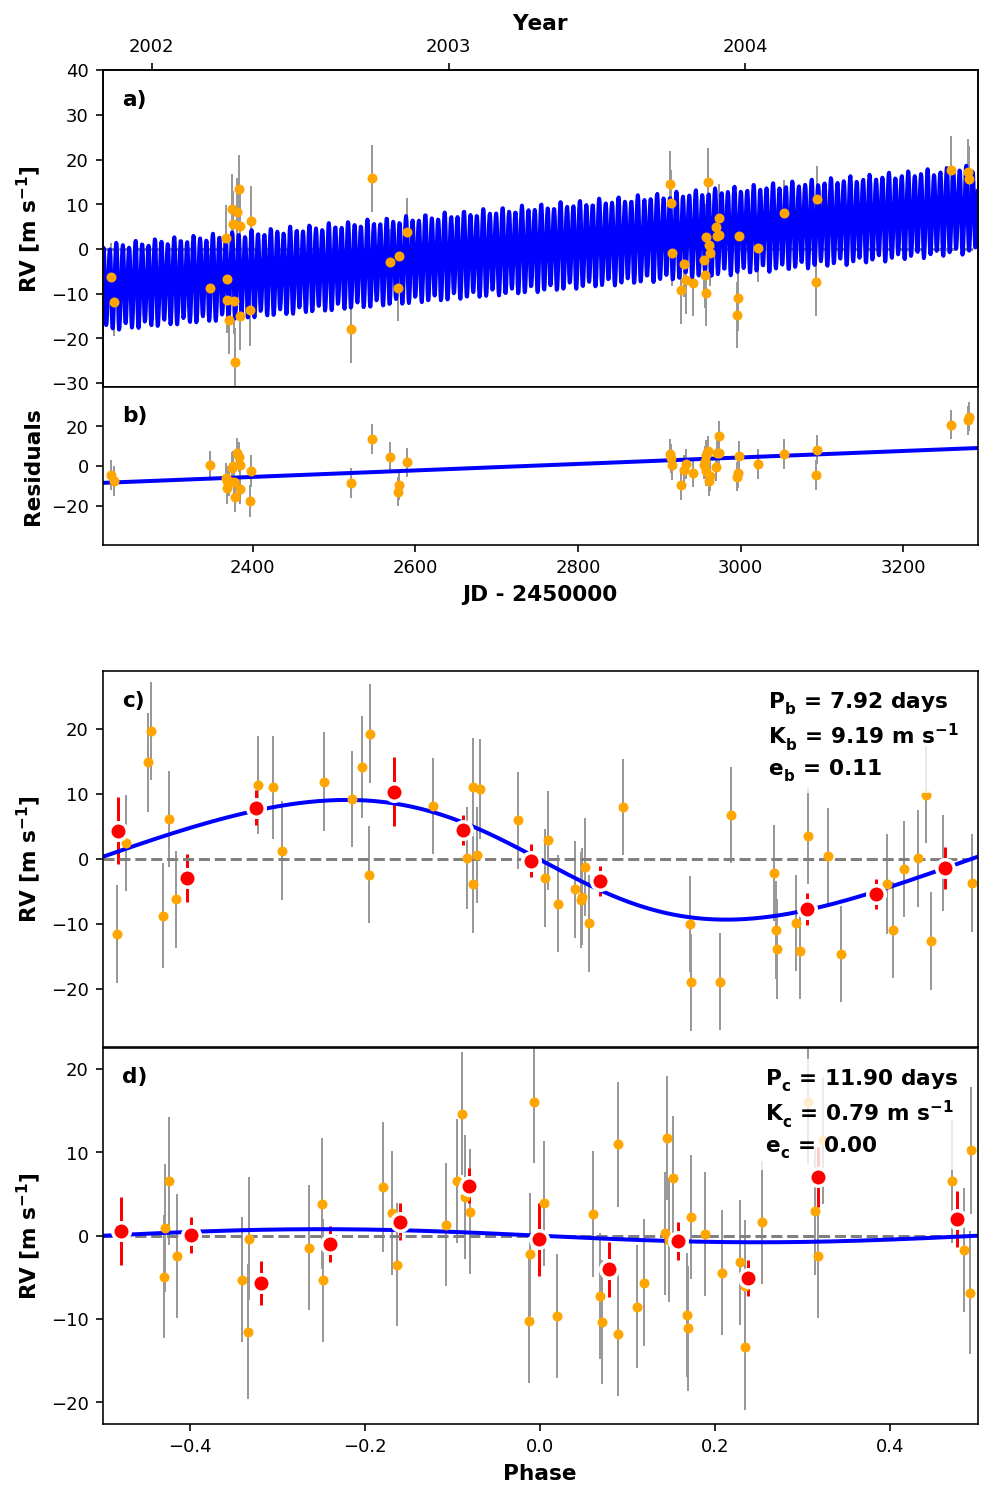

In [11]:
%run analysis/radvel/ktwo19_npl=2-default.py
params['secosw1'] = radvel.Parameter(value=0.00,vary=True,mcmcscale=0.01)
params['sesinw1'] = radvel.Parameter(value=0.00,vary=True,mcmcscale=0.01)
params['secosw2'] = radvel.Parameter(value=0.00,vary=False,mcmcscale=0.01)
params['sesinw2'] = radvel.Parameter(value=0.00,vary=False,mcmcscale=0.01)
params['secosw3'] = radvel.Parameter(value=0.00,vary=False,mcmcscale=0.01)
params['sesinw3'] = radvel.Parameter(value=0.00,vary=False,mcmcscale=0.01)
model = radvel.model.RVModel(params,time_base=time_base)
like = radvel.likelihood.RVLikelihood(model, data.time, data.mnvel,data.errvel)
like.params['dvdt'].vary = True
like.params['gamma'] = radvel.Parameter(value=data.mnvel.mean())
like.params['jit'] = radvel.Parameter(value=1)
like = radvel.likelihood.CompositeLikelihood([like])
post = radvel.posterior.Posterior(like)    
post.priors += [radvel.prior.EccentricityPrior(3)]

res = optimize.minimize(
    post.neglogprob_array, post.get_vary_params(), method='Powell',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)
print(post)
plotter = orbit_plots.MultipanelPlot(post)
plotter.plot_multipanel()
print "AIC = {:.1f}".format( post.aic())
print "BIC' = {:.1f}".format( bic2(post))

In [3]:
chains = radvel.mcmc(post,nrun=1000,ensembles=3)
print  chains.describe().ix[['mean','std']].T.to_string(float_format='%.3f')

7500/150000 (5.0%) steps complete; Running 7963.51 steps/s; Mean acceptance rate = 52.8%; Min Tz = 418.3; Max G-R = 1.007      
Discarding burn-in now that the chains are marginally well-mixed

150000/150000 (100.0%) steps complete; Running 7006.92 steps/s; Mean acceptance rate = 46.9%; Min Tz = 969.0; Max G-R = 1.003      

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.
                  mean   std
k1               9.054 1.840
k2               0.691 1.654
secosw1         -0.022 0.190
sesinw1          0.121 0.276
dvdt             0.016 0.004
gamma           -2.690 1.206
jit              7.785 0.935
lnprobability -178.471 1.930


/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


         mean   std
ecosw1 -0.009 0.079
esinw1  0.057 0.135
0.3270191811308455


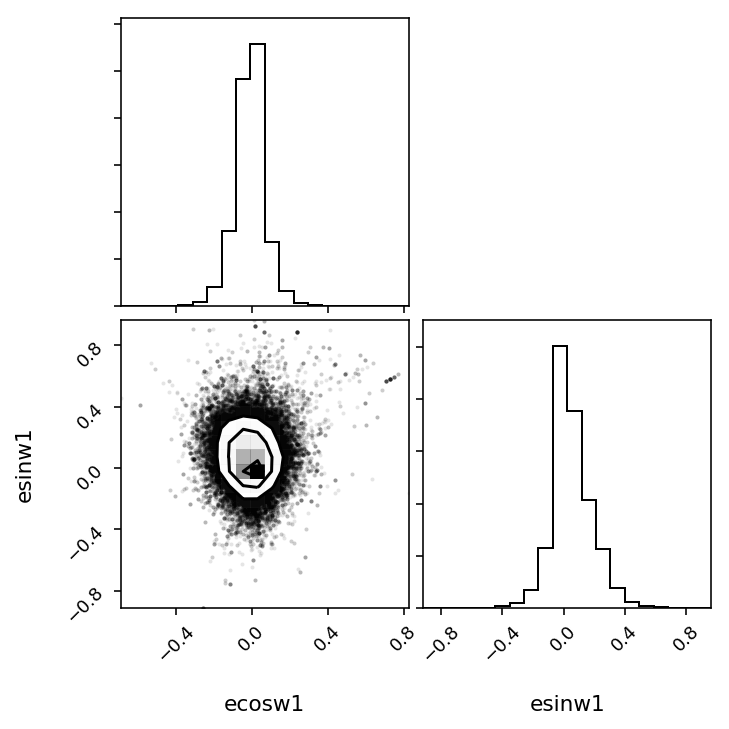

In [4]:
chains['e1'] = chains.eval('secosw1**2 + sesinw1**2')
chains['ecosw1'] = chains.eval('sqrt(e1)*secosw1')
chains['esinw1'] = chains.eval('sqrt(e1)*sesinw1')
import corner
corner.corner(chains[['ecosw1','esinw1']])
print chains['ecosw1 esinw1'.split()].describe().ix[['mean','std']].T.to_string(float_format='%.3f')
print chains['e1'].quantile(0.95)

### Look for correlated structure in the residuals

<Container object of 3 artists>

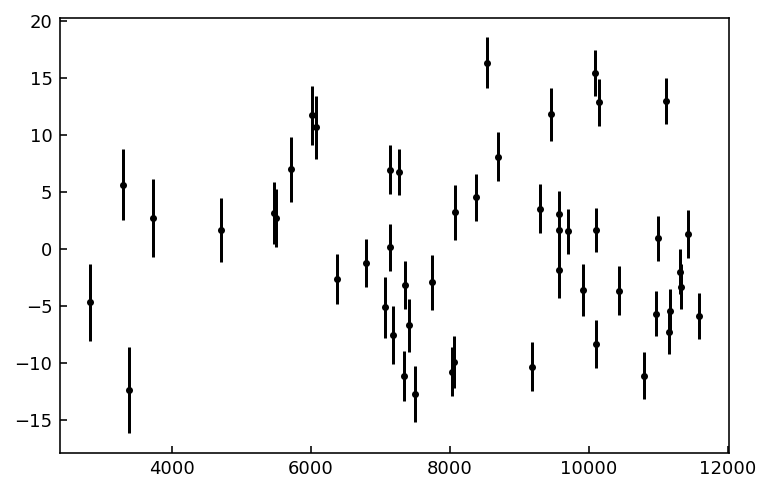

In [15]:
errorbar(data.cts,post.likelihood.residuals(),yerr=post.likelihood.yerr,fmt='.')

### Examine pointwise correlation

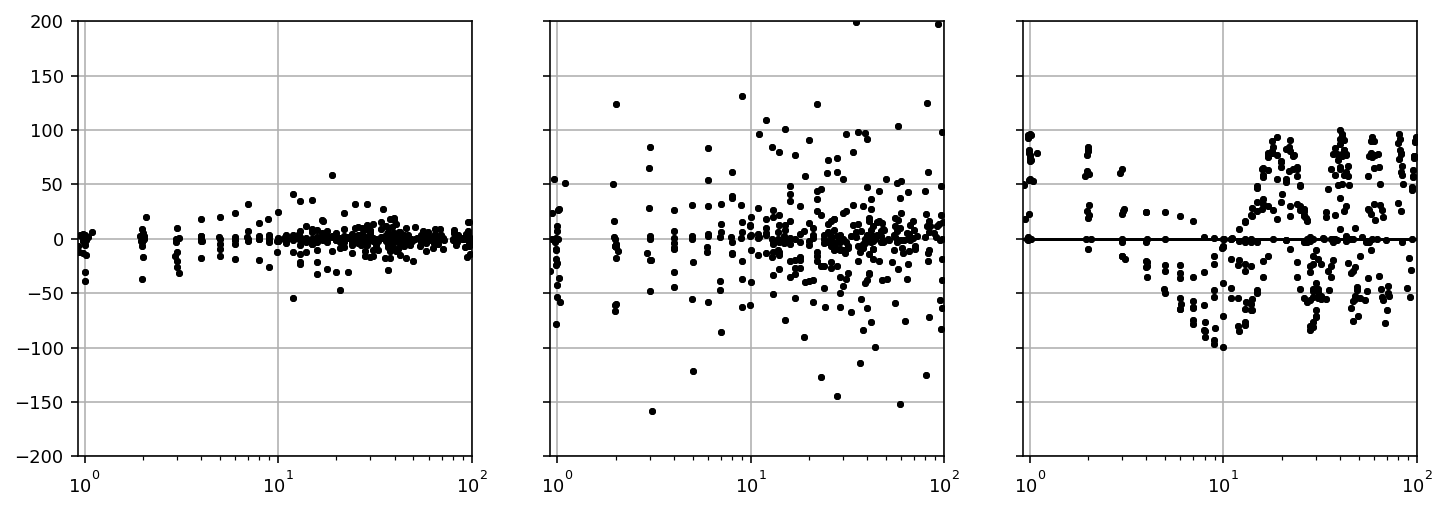

In [11]:
r = post.likelihood.residuals()
t = post.likelihood.x
lag,prod = lagprod(t,r)
  
r = np.random.randn(len(t))* 7
lag,prod_white = lagprod(t,r)


r = np.sin(2*pi*t / 20) * 10
lag,prod_sin = lagprod(t,r)


fig, axL = subplots(ncols=3,figsize=(12,4),sharex=True,sharey=True)
sca(axL[0])
semilogx()
grid()

plot(lag,prod,'.')
sca(axL[1])
plot(lag,prod_white,'.')
grid()


sca(axL[2])
plot(lag,prod_sin,'.')
grid()


xlim(0,100)
ylim(-200,200)
axhline(0)

test = pd.DataFrame(dict(lag=lag,prod=prod))
g = test.groupby(pd.cut(test.lag,bins=np.logspace(log10(1),log10(1000),1000)))
mn = g.mean()
#plot(mn.lag,mn['prod'],'o')


(1, 100)

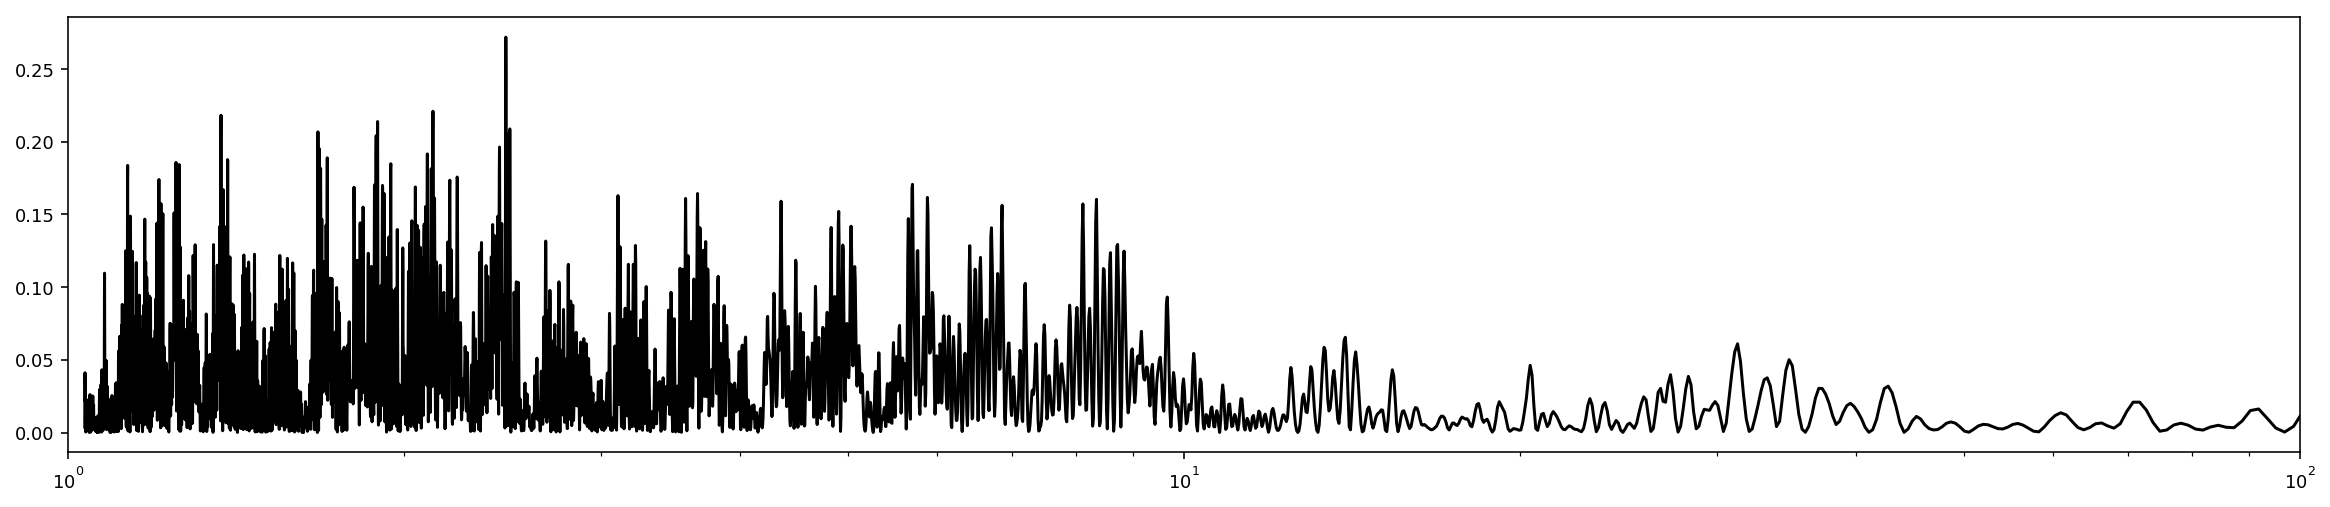

In [12]:
from astropy.stats import LombScargle
ls = LombScargle(post.likelihood.x - post.likelihood.x.mean(), post.likelihood.residuals())
frequency, power = ls.autopower(nyquist_factor=40)
figure(figsize=(20,4))
semilogx(1/frequency, power)
xlim(1,100)

In [13]:
chains = radvel.mcmc(post,nrun=1000,ensembles=3)
print  chains.describe().ix[['mean','std']].T.to_string(float_format='%.3f')

7500/150000 (5.0%) steps complete; Running 2532.49 steps/s; Mean acceptance rate = 60.0%; Min Tz = 1337.0; Max G-R = 1.002      
Discarding burn-in now that the chains are marginally well-mixed

75000/150000 (50.0%) steps complete; Running 2092.36 steps/s; Mean acceptance rate = 55.0%; Min Tz = 2149.9; Max G-R = 1.001      
Chains are well-mixed after 75000 steps! MCMC completed in 30.3 seconds


                  mean   std
k1              11.881 1.662
k2               0.230 1.728
gp_amp           9.356 1.992
gamma_j         -1.969 2.634
jit_j            3.823 1.096
lnprobability -185.329 1.770


/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


## Model 3: Circular orbits, no trend, GP

excluding obs: rj197.149


/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:34: OptimizeWarning: Unknown solver options: xatol


parameter                     value      vary
per1                        7.92075      False
k1                          11.8917       True
per2                         11.898      False
k2                         0.230022       True
tc1                         1980.38      False
secosw1                           0      False
sesinw1                           0      False
tc2                          1984.3      False
secosw2                           0      False
sesinw2                           0      False
dvdt                              0      False
curv                              0      False
gp_amp                      8.48889       True
gp_explength                33.9844      False
gp_per                      20.3878      False
gp_perlength                 0.4859      False
gamma_j                      -1.956       True
jit_j                       3.61865       True

Priors
------
Jeffrey's prior on gp_amp, min=0.1, max=30.0
Gaussian prior on gp_explength, mu=33.984398, si

<Figure size 432x288 with 0 Axes>

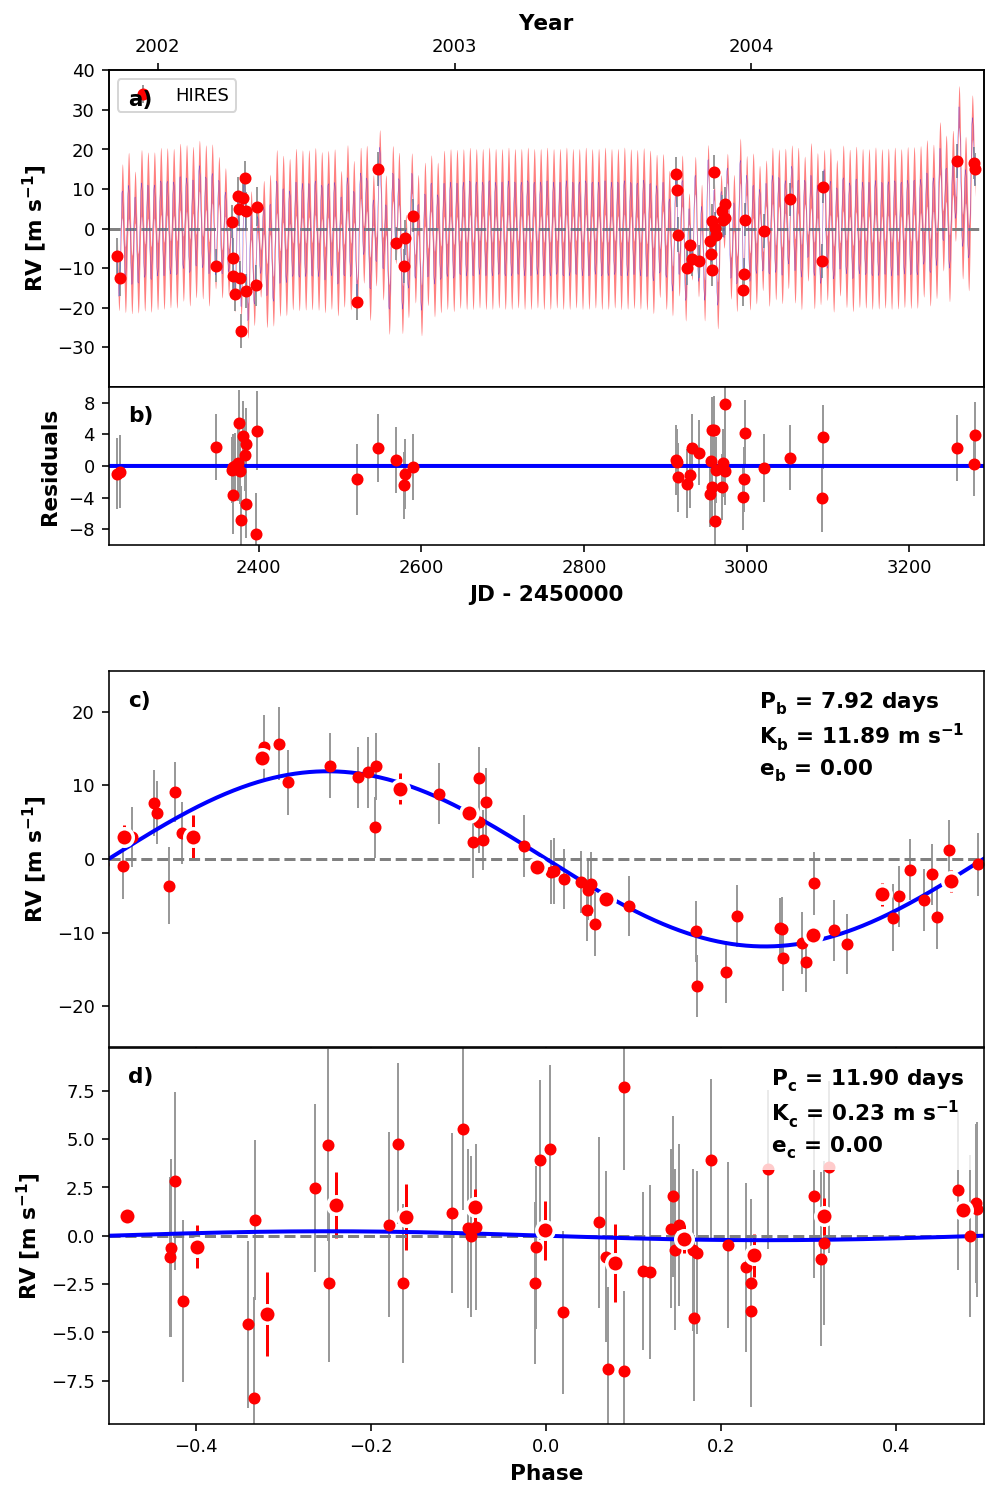

In [14]:
%run analysis/radvel/ktwo19_npl=2-default.py
model = radvel.model.RVModel(params,time_base=time_base)

# Add in GP parameters
hnames = [
    'gp_amp', # eta_1; GP variability amplitude
    'gp_explength', # eta_2; GP non-periodic characteristic length
    'gp_per', # eta_3; GP variability period
    'gp_perlength', # eta_4; GP periodic characteristic length
]
params['gp_amp'] = radvel.Parameter(value=5,vary=True)
params['gp_explength'] = radvel.Parameter(value=gphot.eta2,vary=False)
params['gp_per'] = radvel.Parameter(value=gphot.eta3,vary=False)
params['gp_perlength'] = radvel.Parameter(value=gphot.eta4,vary=False)
like = radvel.likelihood.GPLikelihood(
    model, data.time, data.mnvel,data.errvel, hnames, suffix='_j',
    kernel_name="QuasiPer"
)

model = radvel.model.RVModel(params,time_base=2500)
like.params['gamma_j'] = radvel.Parameter(value=data.mnvel.mean())
like.params['jit_j'] = radvel.Parameter(value=1)
like = radvel.likelihood.CompositeLikelihood([like])

post = radvel.posterior.Posterior(like)    
post.priors += [radvel.prior.Jeffreys('gp_amp', 0.1, 30.)]
post.priors += [radvel.prior.Gaussian('gp_explength', gphot.eta2, gphot.eta2_err)]
post.priors += [radvel.prior.Gaussian('gp_per', gphot.eta3, gphot.eta3_err)]
post.priors += [radvel.prior.Gaussian('gp_perlength', gphot.eta4, gphot.eta4_err)]
post.priors += [radvel.prior.Jeffreys('jit_j', 0.01, 10.)]

res = optimize.minimize(
    post.neglogprob_array, post.get_vary_params(), method='Powell',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)


print(post)
plotter = orbit_plots.GPMultipanelPlot(post,subtract_orbit_model=False)
plotter.plot_multipanel()
axL = gcf().get_axes()
sca(axL[0])
ylim(-40,40)
print "BIC = {:.1f}".format( post.bic())
print "AIC = {:.1f}".format( post.aic())
print "BIC' = {:.1f}".format( bic2(post) )


In [9]:
chains = radvel.mcmc(post,nrun=1000,ensembles=3)
print  chains.describe().ix[['mean','std']].T.to_string(float_format='%.1f')

7500/150000 (5.0%) steps complete; Running 2616.86 steps/s; Mean acceptance rate = 59.9%; Min Tz = 1990.7; Max G-R = 1.001      
Discarding burn-in now that the chains are marginally well-mixed

97500/150000 (65.0%) steps complete; Running 2369.04 steps/s; Mean acceptance rate = 55.1%; Min Tz = 1884.0; Max G-R = 1.002      
Chains are well-mixed after 97500 steps! MCMC completed in 40.4 seconds


                mean  std
k1              11.9  1.7
k2               0.2  1.8
gp_amp           9.5  2.0
gamma_j         -2.0  2.7
jit_j            3.8  1.1
lnprobability -185.4  1.8


/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


## Model 4: Circular orbits, trend, GP

In [16]:
%run analysis/radvel/ktwo19_npl=3-default.py
model = radvel.model.RVModel(params,time_base=time_base)

# Add in GP parameters
hnames = [
    'gp_amp', # eta_1; GP variability amplitude
    'gp_explength', # eta_2; GP non-periodic characteristic length
    'gp_per', # eta_3; GP variability period
    'gp_perlength', # eta_4; GP periodic characteristic length
]
params['gp_amp'] = radvel.Parameter(value=5,vary=True)
params['gp_explength'] = radvel.Parameter(value=gphot.eta2,vary=True)
params['gp_per'] = radvel.Parameter(value=gphot.eta3,vary=True)
params['gp_perlength'] = radvel.Parameter(value=gphot.eta4,vary=True)
like = radvel.likelihood.GPLikelihood(
    model, data.time, data.mnvel,data.errvel, hnames, suffix='_j',
    kernel_name="QuasiPer"
)

model = radvel.model.RVModel(params,time_base=2500)
like.params['gamma_j'] = radvel.Parameter(value=data.mnvel.mean())
like.params['jit_j'] = radvel.Parameter(value=1)
like = radvel.likelihood.CompositeLikelihood([like])

post = radvel.posterior.Posterior(like)    
post.priors += [radvel.prior.Jeffreys('gp_amp', 0.1, 30.)]
post.priors += [radvel.prior.Gaussian('gp_explength', gphot.eta2, gphot.eta2_err)]
post.priors += [radvel.prior.Gaussian('gp_per', gphot.eta3, gphot.eta3_err)]
post.priors += [radvel.prior.Gaussian('gp_perlength', gphot.eta4, gphot.eta4_err)]
post.priors += [radvel.prior.Jeffreys('jit_j', 0.01, 10.)]
post.params['dvdt'].vary=True
res = optimize.minimize(
    post.neglogprob_array, post.get_vary_params(), method='Powell',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)

print(post)


excluding obs: rj197.149


/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:34: OptimizeWarning: Unknown solver options: xatol


parameter                     value      vary
per1                        7.92075      False
k1                          11.3723       True
per2                         11.898      False
k2                         0.444708       True
per3                        2.50856      False
k3                         -0.15235       True
tc1                         1980.38      False
secosw1                           0      False
sesinw1                           0      False
tc2                          1984.3      False
secosw2                           0      False
sesinw2                           0      False
tc3                         1975.92      False
secosw3                           0      False
sesinw3                           0      False
dvdt                      0.0163191       True
curv                              0      False
gp_amp                      6.63279       True
gp_explength                34.6977       True
gp_per                      20.3199       True
gp_perlength  

BIC = 397.8
AIC = 384.0
BIC' = 382.7


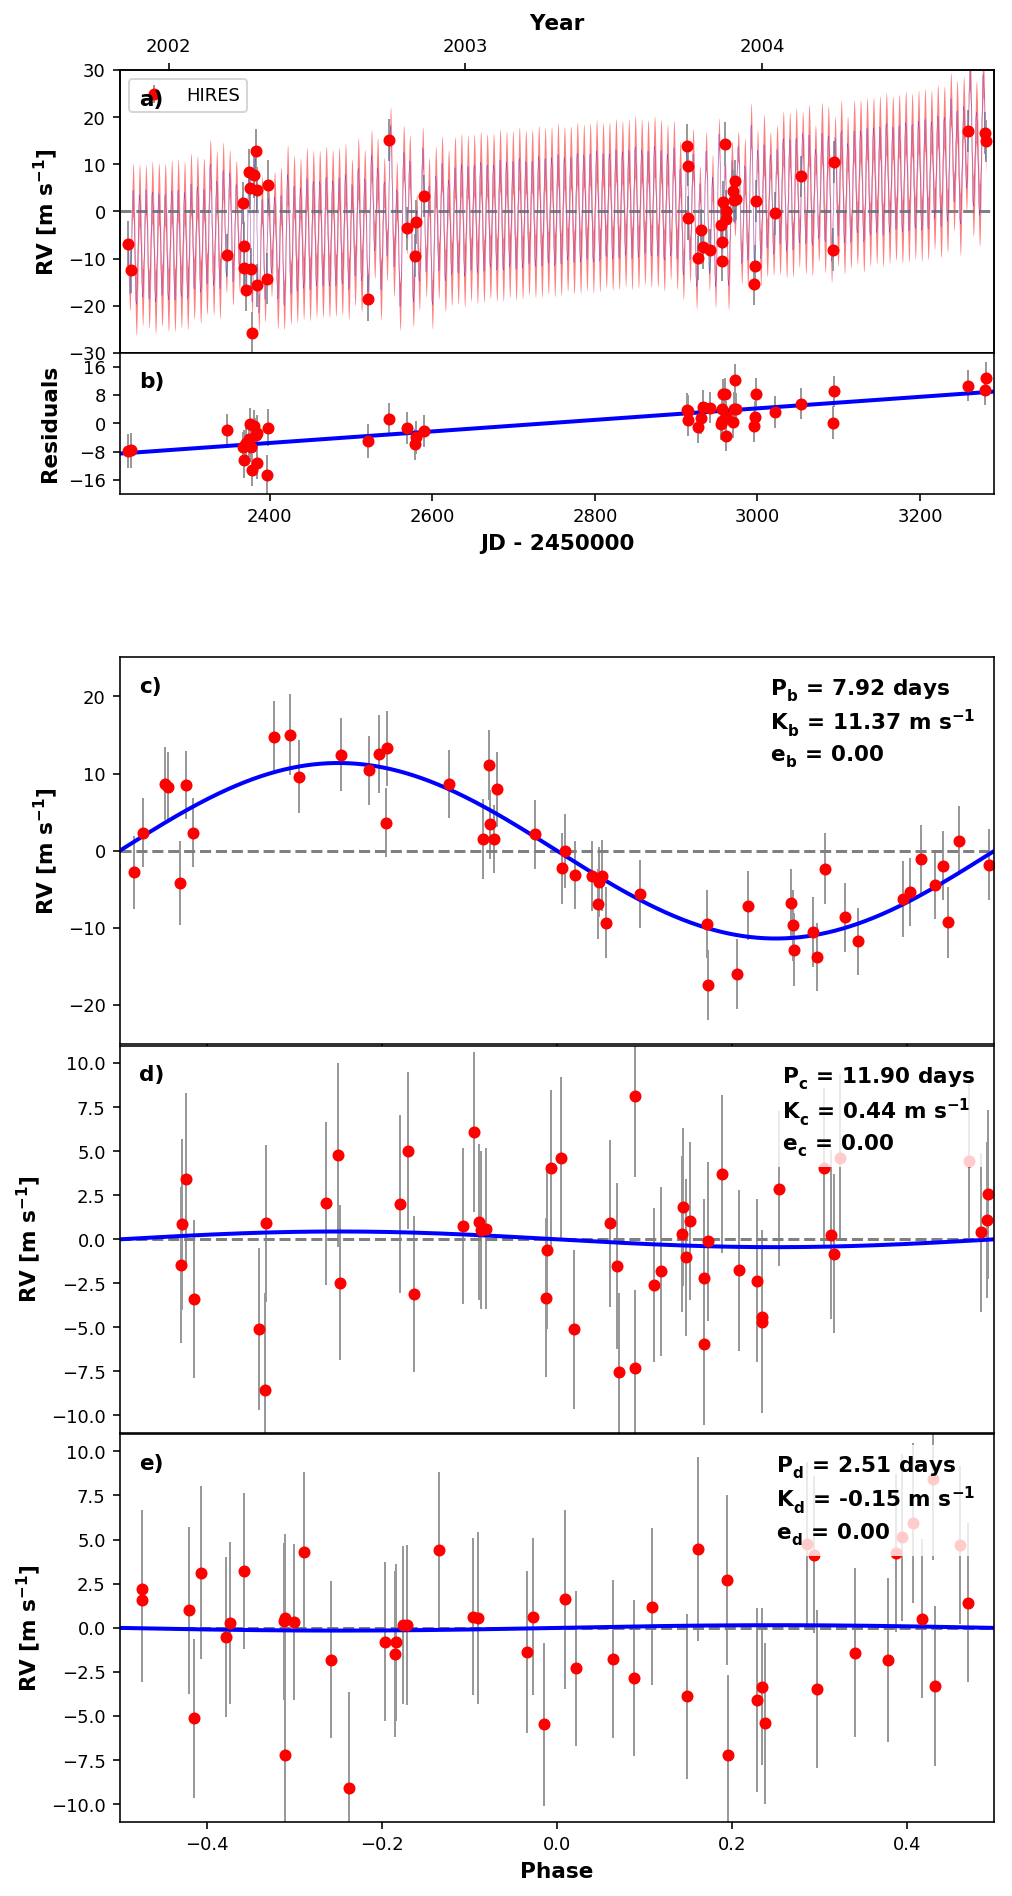

In [17]:

plotter = orbit_plots.GPMultipanelPlot(post,subtract_orbit_model=False,nobin=True)
plotter.plot_multipanel()
fig = gcf()
axL = fig.get_axes()

setp(axL[0:2],ylim=(-30,30))

#setp(axL[0:3],ylim=(-30,30),xlim=(2360,2400))
#setp(axL[0:3],ylim=(-20,20),xlim=(2500,2600))
#setp(axL[0:3],ylim=(-20,20),xlim=(2900,3000))


print "BIC = {:.1f}".format( post.bic())
print "AIC = {:.1f}".format( post.aic())
print "BIC' = {:.1f}".format( bic2(post))
fig.savefig('fig_rv.pdf') 

In [18]:
chains = radvel.mcmc(post,nrun=1000,ensembles=3)
print  chains.describe().ix[['mean','std']].T.to_string(float_format='%.3f')

7500/150000 (5.0%) steps complete; Running 2297.68 steps/s; Mean acceptance rate = 47.1%; Min Tz = 714.9; Max G-R = 1.004      
Discarding burn-in now that the chains are marginally well-mixed

82500/150000 (55.0%) steps complete; Running 2094.42 steps/s; Mean acceptance rate = 40.6%; Min Tz = 1609.0; Max G-R = 1.002      
Chains are well-mixed after 82500 steps! MCMC completed in 38.4 seconds


                  mean   std
k1              11.277 1.815
k2               0.367 1.514
k3              -0.181 1.070
dvdt             0.016 0.007
gp_amp           7.158 2.619
gp_explength    34.814 5.026
gp_per          20.336 0.331
gp_perlength     0.457 0.069
gamma_j         -2.031 2.146
jit_j            4.480 1.495
lnprobability -184.621 2.417


/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


## Model 6: Eccentric planet b, trend, GP 

In [5]:
%run analysis/radvel/ktwo19_npl=3-default.py
model = radvel.model.RVModel(params,time_base=time_base)


params['secosw1'] = radvel.Parameter(value=0.00,vary=True,mcmcscale=0.01)
params['sesinw1'] = radvel.Parameter(value=0.00,vary=True,mcmcscale=0.01)
params['secosw2'] = radvel.Parameter(value=0.00,vary=False,mcmcscale=0.01)
params['sesinw2'] = radvel.Parameter(value=0.00,vary=False,mcmcscale=0.01)
params['secosw3'] = radvel.Parameter(value=0.00,vary=False,mcmcscale=0.01)
params['sesinw3'] = radvel.Parameter(value=0.00,vary=False,mcmcscale=0.01)



# Add in GP parameters
hnames = [
    'gp_amp', # eta_1; GP variability amplitude
    'gp_explength', # eta_2; GP non-periodic characteristic length
    'gp_per', # eta_3; GP variability period
    'gp_perlength', # eta_4; GP periodic characteristic length
]
params['gp_amp'] = radvel.Parameter(value=5,vary=True)
params['gp_amp'] = radvel.Parameter(value=5,vary=True)
params['gp_explength'] = radvel.Parameter(value=gphot.eta2,vary=True)
params['gp_per'] = radvel.Parameter(value=gphot.eta3,vary=True)
params['gp_perlength'] = radvel.Parameter(value=gphot.eta4,vary=True)
like = radvel.likelihood.GPLikelihood(
    model, data.time, data.mnvel,data.errvel, hnames, suffix='_j',
    kernel_name="QuasiPer"
)

model = radvel.model.RVModel(params,time_base=2500)
like.params['gamma_j'] = radvel.Parameter(value=data.mnvel.mean())
like.params['jit_j'] = radvel.Parameter(value=1)
like = radvel.likelihood.CompositeLikelihood([like])

post = radvel.posterior.Posterior(like)    
post.priors += [radvel.prior.Jeffreys('gp_amp', 0.1, 30.)]
post.priors += [radvel.prior.Gaussian('gp_explength', gphot.eta2, gphot.eta2_err)]
post.priors += [radvel.prior.Gaussian('gp_per', gphot.eta3, gphot.eta3_err)]
post.priors += [radvel.prior.Gaussian('gp_perlength', gphot.eta4, gphot.eta4_err)]
post.priors += [radvel.prior.Jeffreys('jit_j', 0.01, 10.)]
post.priors += [radvel.prior.EccentricityPrior(3)]

post.params['dvdt'].vary=True
res = optimize.minimize(
    post.neglogprob_array, post.get_vary_params(), method='Powell',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)

print(post)


excluding obs: rj197.149


/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:47: OptimizeWarning: Unknown solver options: xatol
/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/radvel/gp.py:320: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  / (2.*perlength**2)))


parameter                     value      vary
per1                        7.92075      False
k1                          11.9673       True
per2                         11.898      False
k2                          1.01217       True
per3                        2.50856      False
k3                         0.397773       True
tc1                         1980.38      False
secosw1                   -0.231874       True
sesinw1                    0.297456       True
tc2                          1984.3      False
secosw2                           0      False
sesinw2                           0      False
tc3                         1975.92      False
secosw3                           0      False
sesinw3                           0      False
dvdt                      0.0160195       True
curv                              0      False
gp_amp                      6.65506       True
gp_explength                35.0057       True
gp_per                      20.3298       True
gp_perlength  

/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/radvel/likelihood.py:407: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  r = matrix(self._resids()).T
/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


BIC = 402.6
AIC = 387.6
BIC' = 388.0


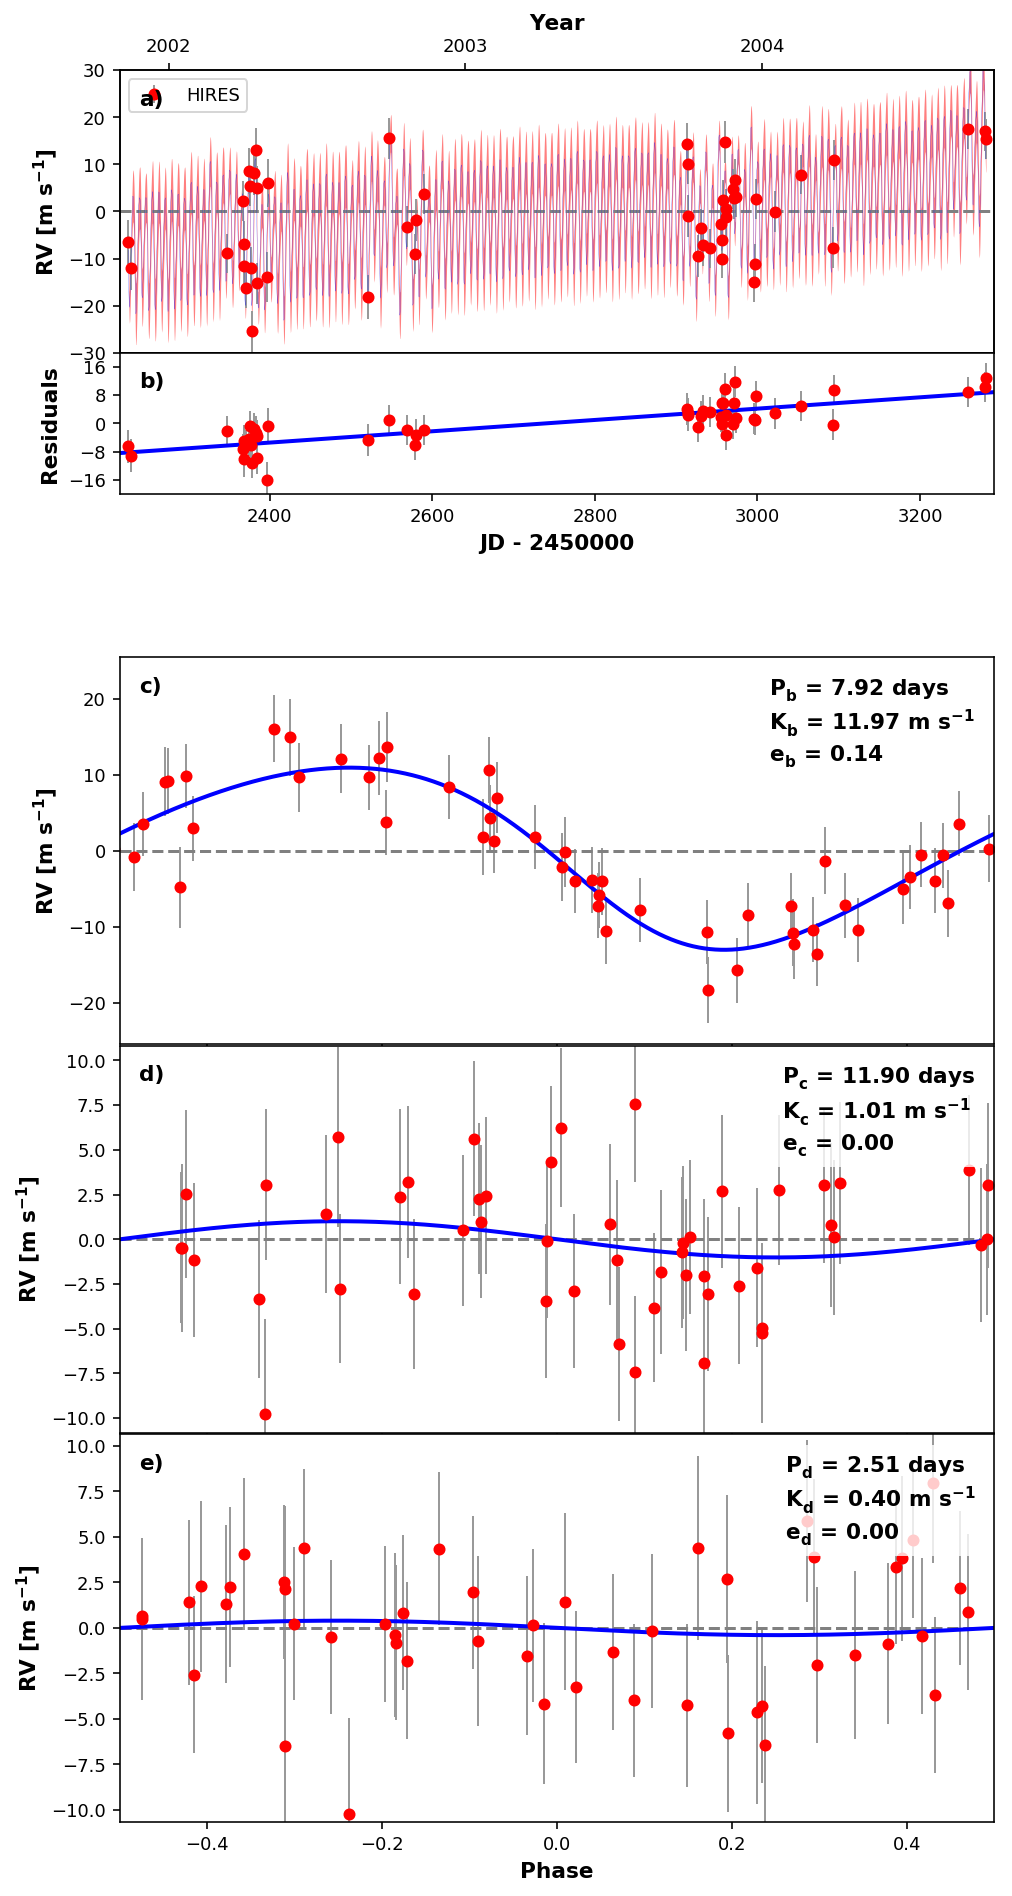

In [6]:

plotter = orbit_plots.GPMultipanelPlot(post,subtract_orbit_model=False,nobin=True)
plotter.plot_multipanel()
fig = gcf()
axL = fig.get_axes()

setp(axL[0:2],ylim=(-30,30))

#setp(axL[0:3],ylim=(-30,30),xlim=(2360,2400))
#setp(axL[0:3],ylim=(-20,20),xlim=(2500,2600))
#setp(axL[0:3],ylim=(-20,20),xlim=(2900,3000))


print "BIC = {:.1f}".format( post.bic())
print "AIC = {:.1f}".format( post.aic())
print "BIC' = {:.1f}".format( bic2(post))
fig.savefig('fig_rv.pdf') 

In [7]:
chains = radvel.mcmc(post,nrun=10000,ensembles=3)
print  chains.describe().ix[['mean','std']].T.to_string(float_format='%.3f')

75000/1500000 (5.0%) steps complete; Running 1878.60 steps/s; Mean acceptance rate = 37.4%; Min Tz = 813.3; Max G-R = 1.004      
Discarding burn-in now that the chains are marginally well-mixed

450000/1500000 (30.0%) steps complete; Running 1968.30 steps/s; Mean acceptance rate = 35.5%; Min Tz = 1295.2; Max G-R = 1.002      
Chains are well-mixed after 450000 steps! MCMC completed in 3.9 minutes


                  mean   std
k1              11.369 1.829
k2               0.774 1.717
k3               0.194 1.237
secosw1         -0.133 0.163
sesinw1          0.144 0.224
dvdt             0.016 0.007
gp_amp           7.100 2.396
gp_explength    35.149 4.645
gp_per          20.339 0.315
gp_perlength     0.470 0.065
gamma_j         -2.265 2.167
jit_j            4.535 1.376
lnprobability -184.327 2.623


/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Populating the interactive namespace from numpy and matplotlib
0.26710978905491245


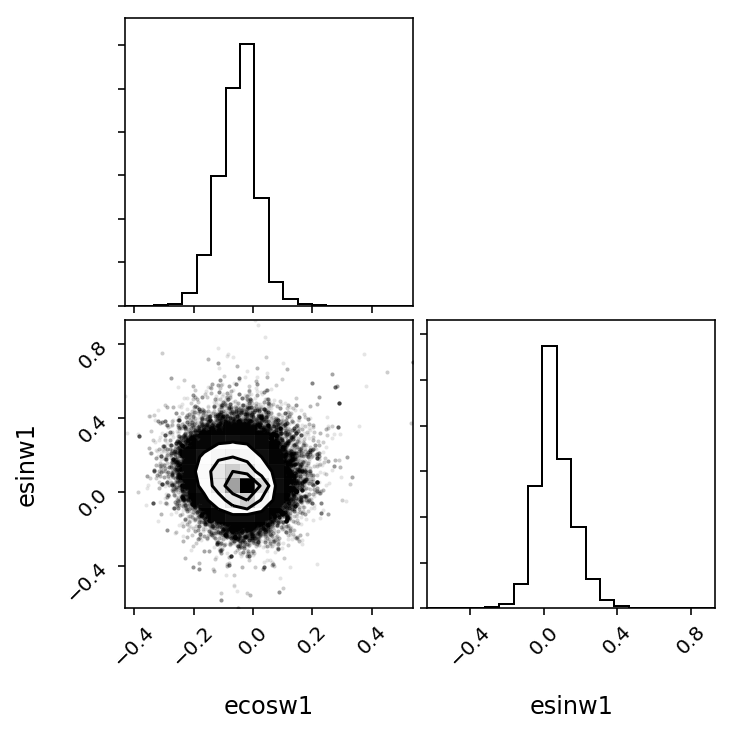

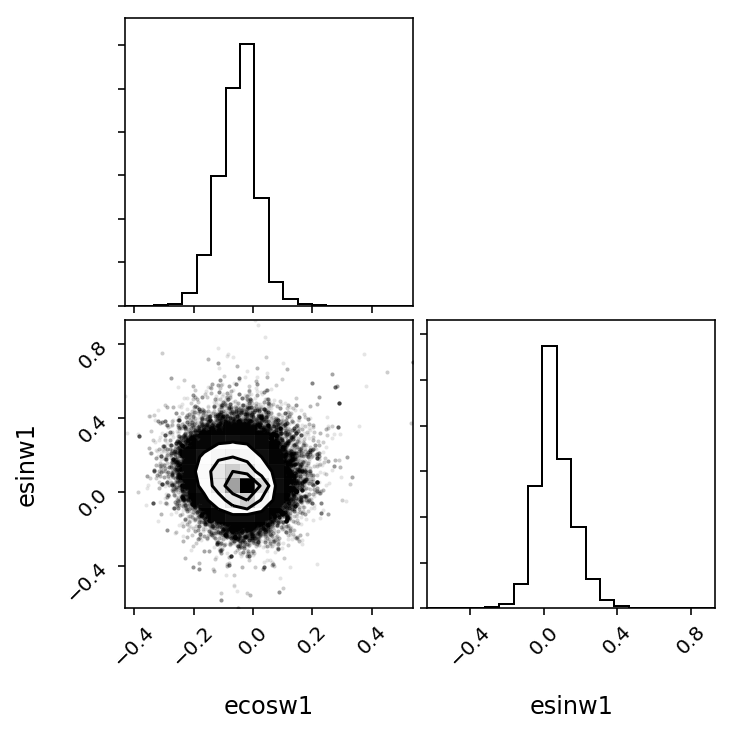

In [9]:
%pylab inline
chains['e1'] = chains.eval('secosw1**2 + sesinw1**2')
chains['ecosw1'] = chains.eval('sqrt(e1)*secosw1')
chains['esinw1'] = chains.eval('sqrt(e1)*sesinw1')
cols = 'ecosw1 esinw1'.split()
print chains['e1'].quantile(0.95)



,k1,k2,k3,secosw1,sesinw1,dvdt,gp_amp,gp_explength,gp_per,gp_perlength,gamma_j,jit_j,lnprobability,e1,ecosw1,esinw1
0,11.475787,-0.445793,-0.023566,-0.190280,0.119625,0.006359,8.467479,37.221512,20.549742,0.522907,-3.521466,4.929667,-182.027622,0.050516,-0.042767,0.026887
1,13.993450,3.682603,-0.355643,-0.137775,0.263412,0.010668,9.687858,34.628814,20.873344,0.546673,0.135855,4.369221,-182.080621,0.088368,-0.040956,0.078304
2,12.003780,-0.463577,1.027194,-0.252411,0.348196,0.016609,7.046202,34.025119,19.897822,0.459358,-3.185528,3.350572,-182.080621,0.184952,-0.108552,0.149745
3,11.492666,-0.444553,-0.022243,-0.189903,0.123810,0.006254,8.512902,37.257107,20.549395,0.523272,-3.542416,4.933543,-182.080621,0.051392,-0.043051,0.028068
4,13.993450,3.682603,-0.355643,-0.137775,0.263412,0.010668,9.687858,34.628814,20.873344,0.546673,0.135855,4.369221,-182.080621,0.088368,-0.040956,0.078304
5,11.325854,-1.095013,2.259575,-0.361243,0.336975,0.009314,6.665447,34.178832,19.643359,0.412317,-3.561082,3.221687,-182.080621,0.244048,-0.178459,0.166470
6,11.492666,-0.444553,-0.022243,-0.189903,0.123810,0.006254,8.512902,37.257107,20.549395,0.523272,-3.542416,4.933543,-184.417612,0.051392,-0.043051,0.028068
7,13.718932,3.785709,-0.582058,-0.144638,0.261404,0.011762,9.156661,34.496920,20.748448,0.532993,-0.250326,4.447060,-192.103381,0.089252,-0.043211,0.078095
8,11.325854,-1.095013,2.259575,-0.361243,0.336975,0.009314,6.665447,34.178832,19.643359,0.412317,-3.561082,3.221687,-192.103381,0.244048,-0.178459,0.166470
9,11.492666,-0.444553,-0.022243,-0.189903,0.123810,0.006254,8.512902,37.257107,20.549395,0.523272,-3.542416,4.933543,-191.945240,0.051392,-0.043051,0.028068


Populating the interactive namespace from numpy and matplotlib


/Users/petigura/anaconda2/envs/ktwo19-3/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sca', 'sci', 'xkcd', 'ylabel', 'viridis', 'thetagrids', 'cool', 'get_plot_commands', 'winter', 'plotfile', 'ishold', 'axes', 'violinplot', 'install_repl_displayhook', 'axvline', 'twinx', 'contourf', 'pause', 'rgrids', 'legend', 'box', 'rc_context', 'step', 'broken_barh', 'ginput', 'ticklabel_format', 'plot', 'figure', 'xticks', 'clabel', 'flag', 'hold', 'hist2d', 'scatter', 'spy', 'quiver', 'subplot2grid', 'autumn', 'axis', 'gcf', 'gci', 'csd', 'hot', 'minorticks_off', 'get_figlabels', 'pink', 'yticks', 'colormaps', 'pylab_setup', 'tricontour', 'subplots', 'barbs', 'xlim', 'copper', 'over', 'cla', 'subplot_tool', 'suptitle', 'waitforbuttonpress', 'bone', 'connect', 'margins', 'uninstall_repl_displayhook', 'streamplot', 'rc', 'plotting', 'specgram', 'acorr', 'eventplot', 'ion', 'semilogx', 'semilogy', 'gca', 'subplots_adjust', '

TypeError: unbound method __init__() must be called with Affine2DBase instance as first argument (got Affine2D instance instead)

In [39]:
chains

,k1,k2,k3,secosw1,sesinw1,dvdt,gp_amp,gp_explength,gp_per,gp_perlength,gamma_j,jit_j,lnprobability,e1,ecosw1,esinw1
0,11.475787,-0.445793,-0.023566,-0.190280,0.119625,0.006359,8.467479,37.221512,20.549742,0.522907,-3.521466,4.929667,-182.027622,0.050516,-0.042767,0.026887
1,13.993450,3.682603,-0.355643,-0.137775,0.263412,0.010668,9.687858,34.628814,20.873344,0.546673,0.135855,4.369221,-182.080621,0.088368,-0.040956,0.078304
2,12.003780,-0.463577,1.027194,-0.252411,0.348196,0.016609,7.046202,34.025119,19.897822,0.459358,-3.185528,3.350572,-182.080621,0.184952,-0.108552,0.149745
3,11.492666,-0.444553,-0.022243,-0.189903,0.123810,0.006254,8.512902,37.257107,20.549395,0.523272,-3.542416,4.933543,-182.080621,0.051392,-0.043051,0.028068
4,13.993450,3.682603,-0.355643,-0.137775,0.263412,0.010668,9.687858,34.628814,20.873344,0.546673,0.135855,4.369221,-182.080621,0.088368,-0.040956,0.078304
5,11.325854,-1.095013,2.259575,-0.361243,0.336975,0.009314,6.665447,34.178832,19.643359,0.412317,-3.561082,3.221687,-182.080621,0.244048,-0.178459,0.166470
6,11.492666,-0.444553,-0.022243,-0.189903,0.123810,0.006254,8.512902,37.257107,20.549395,0.523272,-3.542416,4.933543,-184.417612,0.051392,-0.043051,0.028068
7,13.718932,3.785709,-0.582058,-0.144638,0.261404,0.011762,9.156661,34.496920,20.748448,0.532993,-0.250326,4.447060,-192.103381,0.089252,-0.043211,0.078095
8,11.325854,-1.095013,2.259575,-0.361243,0.336975,0.009314,6.665447,34.178832,19.643359,0.412317,-3.561082,3.221687,-192.103381,0.244048,-0.178459,0.166470
9,11.492666,-0.444553,-0.022243,-0.189903,0.123810,0.006254,8.512902,37.257107,20.549395,0.523272,-3.542416,4.933543,-191.945240,0.051392,-0.043051,0.028068


In [51]:
import ktwo19.io
reload(ktwo19.io)
import ktwo19.keplerian
reload(ktwo19.keplerian)

ktwo19.io.load_table('keplerian-samples',cache=1)

Cache not built for table: keplerian-samples
Building cache...
excluding obs: rj197.149
excluding obs: rj197.149
7500/150000 (5.0%) steps complete; Running 4478.03 steps/s; Mean acceptance rate = 47.1%; Min Tz = 633.1; Max G-R = 1.005      
Discarding burn-in now that the chains are marginally well-mixed

112500/150000 (75.0%) steps complete; Running 4221.27 steps/s; Mean acceptance rate = 40.9%; Min Tz = 1382.4; Max G-R = 1.002      
Chains are well-mixed after 112500 steps! MCMC completed in 26.9 seconds


writing table keplerian-samples to cache


/Users/petigura/anaconda2/lib/python2.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'keplerian-samples'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


,k1,k2,k3,dvdt,gp_amp,gp_explength,gp_per,gp_perlength,gamma_j,jit_j,lnprobability
0,10.262649,0.197695,-0.047904,0.012807,7.035647,30.152901,20.188433,0.542452,-2.711607,5.207194,-181.984604
1,9.588337,0.406802,-0.131867,0.013221,9.280659,28.824057,20.084855,0.520138,-2.546765,3.904446,-181.984604
2,10.266369,0.468320,-0.019968,0.020806,6.726796,44.351072,20.469019,0.367552,-2.614139,3.805293,-181.786290
3,10.262649,0.197695,-0.047904,0.012807,7.035647,30.152901,20.188433,0.542452,-2.711607,5.207194,-181.786290
4,9.149114,0.286850,-0.105485,0.010938,10.618099,28.353245,20.289219,0.514899,-2.368100,3.603835,-181.786290
5,10.266369,0.468320,-0.019968,0.020806,6.726796,44.351072,20.469019,0.367552,-2.614139,3.805293,-182.127742
6,11.280408,0.462550,-0.077323,0.014315,6.796076,30.195419,20.124455,0.540917,-2.050146,5.340412,-182.127742
7,9.149114,0.286850,-0.105485,0.010938,10.618099,28.353245,20.289219,0.514899,-2.368100,3.603835,-182.109680
8,10.266369,0.468320,-0.019968,0.020806,6.726796,44.351072,20.469019,0.367552,-2.614139,3.805293,-182.109680
9,11.280408,0.462550,-0.077323,0.014315,6.796076,30.195419,20.124455,0.540917,-2.050146,5.340412,-182.536025


In [66]:
import ktwo19.io
reload(ktwo19.io)
ktwo19.io.load_table('keplerian-samples-derived')

read table keplerian-samples from load_table_cache.hdf


,k1,k2,k3,dvdt,gp_amp,gp_explength,gp_per,gp_perlength,gamma_j,jit_j,lnprobability,smass,masse1,muppm1,masse2,muppm2,masse3,muppm3
0,10.262649,0.197695,-0.047904,0.012807,7.035647,30.152901,20.188433,0.542452,-2.711607,5.207194,-181.984604,0.919029,30.236750,98.816395,0.667283,2.180739,-0.096210,-0.314424
1,9.588337,0.406802,-0.131867,0.013221,9.280659,28.824057,20.084855,0.520138,-2.546765,3.904446,-181.984604,0.894723,27.749713,93.152184,1.348767,4.527635,-0.260153,-0.873300
2,10.266369,0.468320,-0.019968,0.020806,6.726796,44.351072,20.469019,0.367552,-2.614139,3.805293,-181.786290,0.870097,29.164300,100.671569,1.524108,5.261033,-0.038668,-0.133478
3,10.262649,0.197695,-0.047904,0.012807,7.035647,30.152901,20.188433,0.542452,-2.711607,5.207194,-181.786290,0.866746,29.078819,100.764645,0.641729,2.223735,-0.092526,-0.320623
4,9.149114,0.286850,-0.105485,0.010938,10.618099,28.353245,20.289219,0.514899,-2.368100,3.603835,-181.786290,0.875825,26.104382,89.519820,0.937620,3.215384,-0.205165,-0.703574
5,10.266369,0.468320,-0.019968,0.020806,6.726796,44.351072,20.469019,0.367552,-2.614139,3.805293,-182.127742,0.881648,29.421839,100.229993,1.537567,5.237957,-0.039010,-0.132893
6,11.280408,0.462550,-0.077323,0.014315,6.796076,30.195419,20.124455,0.540917,-2.050146,5.340412,-182.127742,0.898144,32.729929,109.451575,1.537509,5.141556,-0.152935,-0.511426
7,9.149114,0.286850,-0.105485,0.010938,10.618099,28.353245,20.289219,0.514899,-2.368100,3.603835,-182.109680,0.817146,24.924984,91.613285,0.895259,3.290577,-0.195896,-0.720028
8,10.266369,0.468320,-0.019968,0.020806,6.726796,44.351072,20.469019,0.367552,-2.614139,3.805293,-182.109680,0.939925,30.704474,98.114180,1.604597,5.127386,-0.040710,-0.130088
9,11.280408,0.462550,-0.077323,0.014315,6.796076,30.195419,20.124455,0.540917,-2.050146,5.340412,-182.536025,0.921374,33.291863,108.523926,1.563906,5.097979,-0.155560,-0.507091


In [22]:
df = pd.read_csv('data/livingston-lc-fits/201505350.01-mcmc-samples.csv.gz')

In [23]:
import corner
df.describe().T['mean std'.split()]

,mean,std
t0,2.456813e+06,0.000269
p,7.919437e+00,0.000049
k,7.461775e-02,0.000760
a,1.946866e+01,0.645161
b,2.092326e-01,0.127967
q1,4.462596e-01,0.043355
q2,3.640621e-01,0.015512
c0,2.323264e-05,0.000013
ls,-9.011031e+00,0.065893


In [15]:
print "Livingston18 {}".format(0.000760 / 7.461775e-02)
print "Sinkoff15 {}".format(0.00060 / 0.07540)

Livingston18 0.0101852441276
Sinkoff15 0.0079575596817
